In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# todo make a data pipeline with generic interface that can be attached to most model libraries and data transformation libraries

In [2]:
titanic=sns.load_dataset("titanic")
titanic=titanic.select_dtypes(include=['number','boolean'])

In [3]:
titanic.head()

,survived,pclass,age,sibsp,parch,fare,adult_male,alone
0,0,3,22.0,1,0,7.2500,True,False
1,1,1,38.0,1,0,71.2833,False,False
2,1,3,26.0,0,0,7.9250,False,True
3,1,1,35.0,1,0,53.1000,False,False
4,0,3,35.0,0,0,8.0500,True,True


In [31]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=100,random_state=32,
                           task_type="GPU",
                           devices='0')

In [29]:
%%timeit -n100 -r100
_=titanic.sample(frac=0.2)

88.3 µs ± 12.8 µs per loop (mean ± std. dev. of 100 runs, 100 loops each)


In [36]:
titanic_i=np.random.rand(len(titanic))<0.2
Xt=titanic.drop('survived',axis=1).iloc[titanic_i]
yt=titanic['survived'].iloc[titanic_i]
Xe=titanic.drop('survived',axis=1).iloc[~titanic_i]
ye=titanic['survived'].iloc[~titanic_i]

In [103]:
def cross_val(model_init,dataset,ycol,eval_fracs=None,early_stopping_rounds=5):
    if eval_fracs is None: eval_fracs=list([0.1,0.2])
    rounds=[]
    i_array=[]
    eval_scores=[]
    for eval_frac in eval_fracs:
        model=model_init()
        i=np.random.rand(len(dataset))<eval_frac
        Xt=dataset.drop(ycol,axis=1).iloc[i]
        yt=dataset[ycol].iloc[i]
        Xe=dataset.drop(ycol,axis=1).iloc[~i]
        ye=dataset[ycol].iloc[~i]
        model.fit(Xt,yt,eval_set=(Xe,ye),use_best_model=True,verbose=False,early_stopping_rounds=early_stopping_rounds)
        rounds.append(model.get_best_iteration())
        i_array.append(i)
        eval_scores.append(model.score(Xe,ye))
    return model,np.array(rounds),np.array(i_array),np.array(eval_scores)

In [127]:
model,rounds,i_array,eval_scores=cross_val(
    lambda: (CatBoostClassifier(iterations=100,random_state=32,
       task_type="GPU",
       devices='0')),
    titanic,
    'survived',
    [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]*20)

In [128]:
meta=pd.DataFrame({
    'i_mean':i_array.mean(1),
    'rounds':rounds,
    'eval_scores':eval_scores,
})

In [129]:
meta

,i_mean,rounds,eval_scores
0,0.096521,21,0.768944
1,0.197531,16,0.786014
2,0.305275,23,0.791599
3,0.391695,28,0.839483
4,0.489338,38,0.828571
...,...,...,...
175,0.520763,17,0.803279
176,0.582492,25,0.803763
177,0.668911,31,0.847458
178,0.782267,45,0.819588


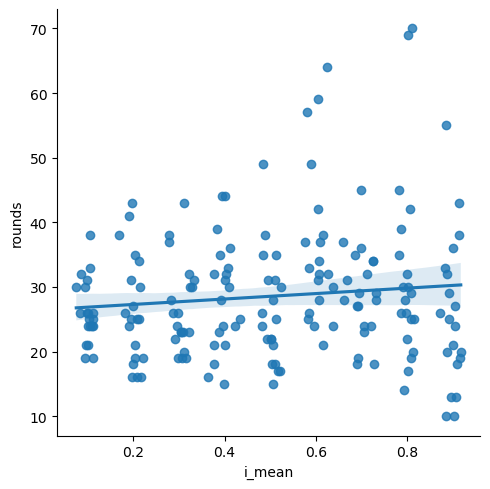

In [131]:
sns.lmplot(data=meta,x='i_mean',y='rounds')

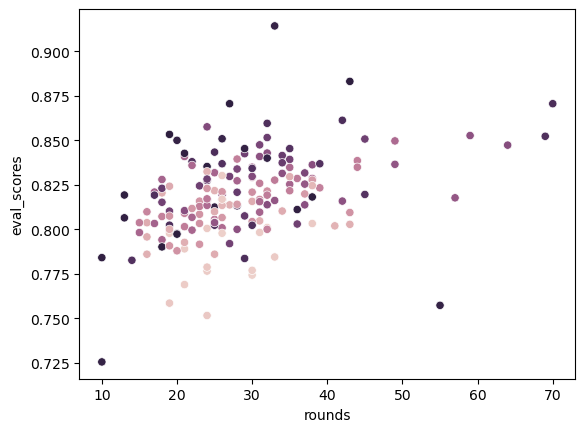

In [141]:
fig,ax=plt.subplots()
sns.scatterplot(data=meta,x='rounds',y='eval_scores',hue='i_mean',ax=ax)
ax.get_legend().set_visible(False)

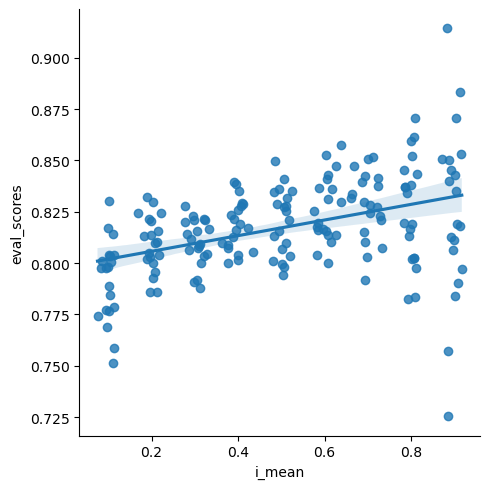

In [133]:
sns.lmplot(data=meta,x='i_mean',y='eval_scores')

In [115]:
pd.Series(np.einsum('i,ij->ij',eval_scores,i_array).sum(0)).sort_values(ascending=False).head(10).index

Index([879, 617, 107, 343, 665, 444, 23, 839, 146, 671], dtype='int64')

In [123]:
pd.Series(np.einsum('i,ij->ij',eval_scores,i_array).sum(0)).sort_values(ascending=False).tail(10).index

Index([481, 493, 506, 512, 518, 522, 527, 531, 532, 890], dtype='int64')

In [111]:
pd.Series(np.einsum('i,ij->ij',eval_scores,i_array).sum(0)).sort_values(ascending=False)

879    8.073831
617    7.351079
107    7.331804
343    7.317351
665    7.301774
         ...   
513    0.000000
477    0.000000
664    0.000000
288    0.000000
752    0.000000
Length: 891, dtype: float64

In [125]:
model.score(
    X.iloc[[719, 327, 811, 487, 193, 104, 436, 254, 667, 838]],
    y.iloc[[719, 327, 811, 487, 193, 104, 436, 254, 667, 838]],
)

0.8

<Axes: ylabel='Frequency'>

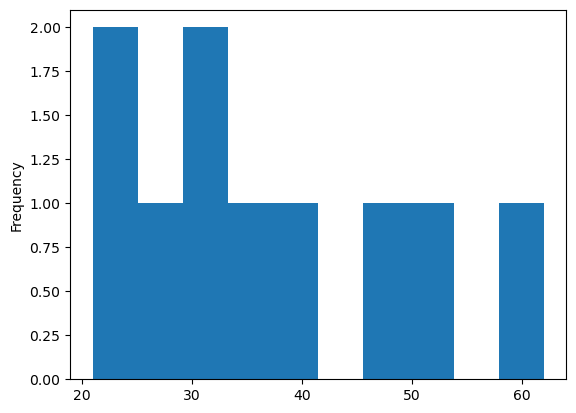

In [69]:
pd.Series(rounds).plot.hist()

In [29]:
X=titanic.drop('survived',axis=1)
y=titanic['survived']

In [38]:
model.fit(Xt,
          yt,
          verbose=False)

In [39]:
model.score(Xe,ye)

0.8033946251768034